In [1]:
## Has a lot of already implemented adversarial attacks like FGSM, PGD, BIM, CW, DeepFool etc.

!pip install torchattacks

     |████████████████████████████████| 105 kB 31.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import cv2
import pickle
import torchattacks
import random
from torchvision import models
import copy
from PIL import Image
import io
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ## FGSM global parameters

# FGSM_EPSILON = 0.15
# loss_fn  = torch.nn.CrossEntropyLoss()

# ## Code loosely from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# def FGSM(model, x, y, fgsm_epsilon):

#     x.requires_grad = True
#     logits = model(x)
#     prediction = F.softmax(logits, dim=1)
#     loss = loss_fn(prediction, y)
#     loss.backward()
    
#     x_grad = x.grad.data
#     sign = x_grad.sign()
#     x_adv = x + fgsm_epsilon*sign
#     x_adv = torch.clamp(x_adv, 0, 1)

#     return x_adv

In [5]:
## Code loosely from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

class FGSM():

    def __init__(self, loss_fn, fgsm_epsilon):

        self.fgsm_epsilon = fgsm_epsilon
        self.loss_fn = loss_fn

    def get_sample(self, model, x, y):
    
        x.requires_grad = True
        logits = model(x)
        prediction = F.softmax(logits, dim=1)
        loss = self.loss_fn(prediction, y)
        loss.backward()
        
        x_grad = x.grad.data
        sign = x_grad.sign()
        x_adv = x + self.fgsm_epsilon*sign
        x_adv = torch.clamp(x_adv, 0, 1)

        return x_adv

In [6]:
# ## CHECK IF FINAL SAMPLE IS IN [0, 1]

# ## PGD global parameters

# loss_fn  = torch.nn.CrossEntropyLoss()
# LOSS_FN  = torch.nn.CrossEntropyLoss()
# NUM_STEPS = 10
# STEP_SIZE = 0.03
# EPS = 0.3     # 0.0, 6.1, 1./3
# STEP_NORM = 2   # 'inf'
# EPS_NORM = 2

# ## Code from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

# def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm,
#                                clamp=(0,1), y_target=None):
#     """Performs the projected gradient descent attack on a batch of images."""
#     # x_adv = x.clone().detach().requires_grad_(True).to(x.device)
#     x_adv = x.clone()
#     targeted = y_target is not None
#     num_channels = x.shape[1]

#     for i in range(num_steps):
#         # _x_adv = x_adv.clone().detach().requires_grad_(True)
#         _x_adv = x_adv.clone()
#         _x_adv.requires_grad = True

#         logits = model(_x_adv)
#         prediction = F.softmax(logits, dim=1)
#         loss = loss_fn(prediction, y_target if targeted else y)
#         loss.backward()

#         # with torch.no_grad():
#             # Force the gradient step to be a fixed size in a certain norm
#         if step_norm == 'inf':
#             gradients = _x_adv.grad.sign() * step_size
#         else:
#                 # Note .view() assumes batched image data as 4D tensor
#             gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
#                 .norm(step_norm, dim=-1)\
#                 .view(-1, num_channels, 1, 1)

#         if targeted:
#                 # Targeted: Gradient descent with on the loss of the (incorrect) target label
#                 # w.r.t. the image data
#             x_adv -= gradients
#         else:
#                 # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
#                 # the model parameters
#             x_adv += gradients

#         # Project back into l_norm ball and correct range
#         if eps_norm == 'inf':
#             # Workaround as PyTorch doesn't have elementwise clip
#             x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
#         else:
#             delta = x_adv - x

#             # Assume x and x_adv are batched tensors where the first dimension is
#             # a batch dimension
#             mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

#             scaling_factor = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1)
#             scaling_factor[mask] = eps

#             # .view() assumes batched images as a 4D Tensor
#             delta *= eps / scaling_factor.view(-1, 1, 1, 1)

#             x_adv = x + delta
            
#         x_adv = x_adv.clamp(*clamp)

#     # return x_adv.detach().cpu()
#     return x_adv

In [7]:
## Code from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

class PGD():

    def __init__(self, loss_fn, num_steps, step_size, eps, step_norm, eps_norm, clamp=(0,1)):

        self.loss_fn = loss_fn
        self.num_steps = num_steps
        self.step_size = step_size
        self.eps = eps
        self.step_norm = step_norm
        self.eps_norm = eps_norm
        self.clamp = clamp

    def get_sample(self, model, x, y, y_target=None):

        x_adv = x.clone().to(device)
        targeted = y_target is not None
        num_channels = x.shape[1]

        for i in range(self.num_steps):
            # _x_adv = x_adv.clone().detach().requires_grad_(True)
            _x_adv = x_adv.clone()
            _x_adv.requires_grad = True

            logits = model(_x_adv)
            prediction = F.softmax(logits, dim=1)
            loss = self.loss_fn(prediction, y_target if targeted else y)
            loss.backward()

                # Force the gradient step to be a fixed size in a certain norm
            if self.step_norm == 'inf':
                gradients = _x_adv.grad.sign() * self.step_size
            else:
                    # Note .view() assumes batched image data as 4D tensor
                gradients = _x_adv.grad * self.step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                    .norm(self.step_norm, dim=-1)\
                    .view(-1, num_channels, 1, 1)

            if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                x_adv -= gradients
            else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                x_adv += gradients

            # Project back into l_norm ball and correct range
            if self.eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv = torch.max(torch.min(x_adv, x + self.eps), x - self.eps)
            else:
                delta = x_adv - x

                # Assume x and x_adv are batched tensors where the first dimension is
                # a batch dimension
                mask = delta.view(delta.shape[0], -1).norm(self.eps_norm, dim=1) <= self.eps

                scaling_factor = delta.view(delta.shape[0], -1).norm(self.eps_norm, dim=1)
                scaling_factor[mask] = self.eps

                # .view() assumes batched images as a 4D Tensor
                delta *= self.eps / scaling_factor.view(-1, 1, 1, 1)

                x_adv = x + delta
                
            x_adv = x_adv.clamp(*self.clamp)

        # return x_adv.detach().cpu()
        return x_adv

In [8]:
## Model from https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [9]:
class LeNet5_Classifier(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_Classifier, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=3),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [10]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [71]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
IMG_SIZE = 32
N_CLASSES = 10

torch.manual_seed(RANDOM_SEED)
adv_model = LeNet5(N_CLASSES).to(device)
if device == 'cpu':
    adv_model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()
else:
    adv_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).to(device)
model = LeNet5_Classifier(N_CLASSES).to(device)
if device == 'cpu':
    model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/All_attacks_varied_params_trained_model-97%.pkl', 'rb')).load()
else:
    model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/All_attacks_varied_params_trained_model-97%.pkl', 'rb')).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

In [72]:
pgd_linf = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.06, eps = 0.3, step_norm = 'inf', eps_norm = 'inf')
pgd_l2 = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 5, step_size = 0.6, eps = 3, step_norm = 2, eps_norm = 2)
fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = 0.2)
cw = torchattacks.CW(adv_model, c=10, kappa=0, steps=5, lr=0.5)
deepfool = torchattacks.DeepFool(adv_model, steps=50, overshoot=0.2)

In [73]:
class MNISTAdversarialDataset(Dataset):

    def __init__(self, df, attack, adv_model, transform=None):
        
        self.df = df
        self.transform = transform
        self.adv_threshold = 0.66
        self.noise_threshold = 0.5
        self.adv_model = adv_model
        self.attack = attack
        self.gn = torchattacks.GN(adv_model, std=2.3)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        y_true = self.df.iloc[idx, 0]
        y_true = torch.tensor(y_true, device=device)
        rand = random.random()
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.df.iloc[idx, 1:]
        img = np.array([img])
        img = np.reshape(img, (28, 28))
        img = Image.fromarray(np.uint8(img))

        if self.transform:
            x = self.transform(img)
        
        x = x.to(device)
        if rand < self.adv_threshold:
            if self.attack == 'pgd-l2':
                x = pgd_l2.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 2
            elif self.attack == 'pgd-linf':
                x = pgd_linf.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 1
            elif self.attack == 'fgsm':
                x = fgsm.get_sample(adv_model, x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                y_true = 1
            elif self.attack == 'deepfool':
                x_adv = deepfool(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                n_changed = torch.sum(x != x_adv).item() / x.size(0)
                if n_changed == 0:
                    y_true = 0
                else:
                    x = x_adv
                    y_true = 2
            elif self.attack == 'cw':
                x_adv = cw(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                n_changed = torch.sum(x != x_adv).item() / x.size(0)
                if n_changed == 0:
                    y_true = 0
                else:
                    x = x_adv
                    y_true = 2
        else:
            rand = random.random()
            if rand < self.noise_threshold:
                if self.attack == 'pgd-linf':
                    self.gn.std = pgd_linf.eps
                    x = self.gn(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                    # x = x + torch.randn(x.size()).to(device) * (pgd_linf.eps**2) + 0
                elif self.attack == 'pgd-l2':
                    self.gn.std = pgd_l2.eps**0.5
                    x = self.gn(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                    # x = x + torch.randn(x.size()).to(device) * (pgd_l2.eps**0.5/(5*pgd_l2.eps)) + 0
                elif self.attack == 'fgsm':
                    self.gn.std = fgsm.fgsm_epsilon
                    x = self.gn(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                    # x = x + torch.randn(x.size()).to(device) * (fgsm.fgsm_epsilon**2) + 0
                elif self.attack == 'cw':
                    x_adv = cw(x.unsqueeze(0).to(device), y_true.unsqueeze(0)).squeeze(0)
                    if torch.sum(x != x_adv).item() != 0:
                        x_adv_flat = x_adv.view(-1)
                        n_changed = torch.sum(x != x_adv).item() / x_adv_flat.size(0)
                        idx = torch.randperm(x_adv_flat.size(0))[:int(x_adv_flat.size(0)*n_changed)]
                        x = x.view(-1)
                        x[idx] = random.random()
                        x = x.view(x_adv.size())
            y_true = 0

        return x.to(device), y_true

### MNIST

In [74]:
data = pd.read_csv('/content/drive/MyDrive/Adversarial Machine Learning/Datasets/MNIST/mnist_train.csv', header=None)
data.columns = data.columns.astype(str)

In [75]:
print(data.head())

   0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  782  \
0  5  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
3  1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
4  9  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   783  784  
0    0    0  
1    0    0  
2    0    0  
3    0    0  
4    0    0  

[5 rows x 785 columns]


In [76]:
train, test = train_test_split(data, test_size=0.2)

In [77]:
BATCH_SIZE = 64

transformations = transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor()]
    )

train_dataset = MNISTAdversarialDataset(train, None, adv_model, transformations)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

valid_dataset = MNISTAdversarialDataset(test, None, adv_model, transformations)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

In [78]:
train_dataset.attack = 'cw'
valid_dataset.attack = 'cw'

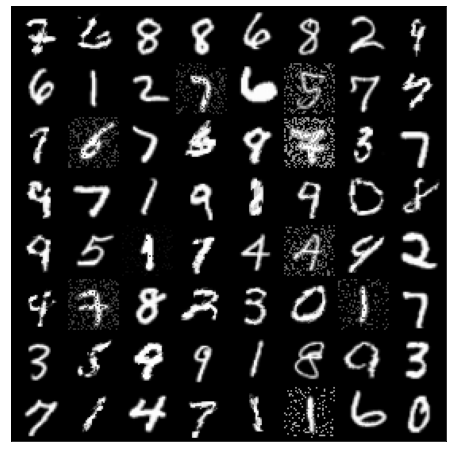

In [79]:
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for samples in dl:
        show_images(samples[0], nmax)
        break

show_batch(train_loader)

### MAIN

In [80]:
def train(train_dataset, train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    attack_list = ['pgd-l2', 'pgd-linf', 'cw']
    
    for X, y_true in tqdm(train_loader):

        rand = random.randint(0,len(attack_list)-1)

        # fgsm_eps = np.random.uniform(0.01, 0.5)
        # fgsm.fgsm_epsilon = fgsm_eps

        pgd_linf_eps = np.random.uniform(0.05, 0.5)
        pgd_linf.eps = pgd_linf_eps
        pgd_linf.step_size = pgd_linf.eps / pgd_linf.num_steps

        pgd_l2_eps = np.random.uniform(2.5, 6)
        pgd_l2.eps = pgd_l2_eps
        pgd_l2.step_size = pgd_l2.eps / pgd_l2.num_steps

        cw.c = random.randint(5, 15)

        train_dataset.attack = attack_list[rand]
        # print(train_dataset.attack)
        
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

In [81]:
def validate(valid_dataset, valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0

    y_pos_prob_total = torch.tensor([], device=device)
    y_true_total = torch.tensor([], device=device)

    attack_list = ['pgd-l2', 'pgd-linf', 'fgsm', 'cw']
    
    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)

        rand = random.randint(0,len(attack_list)-1)

        fgsm_eps = np.random.uniform(0.05, 0.5)
        fgsm.fgsm_epsilon = fgsm_eps

        pgd_linf_eps = np.random.uniform(0.05, 0.5)
        pgd_linf.eps = pgd_linf_eps
        pgd_linf.step_size = pgd_linf.eps / pgd_linf.num_steps

        pgd_l2_eps = np.random.uniform(1.5, 6)
        pgd_l2.eps = pgd_l2_eps
        pgd_l2.step_size = pgd_l2.eps / pgd_l2.num_steps

        cw.c = random.randint(5, 15)

        valid_dataset.attack = attack_list[rand]
        
        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        y_pos_prob_total = torch.cat((y_pos_prob_total, torch.max(y_prob[:, 1:], dim=1)[0]), dim=0)
        y_true_total = torch.cat((y_true_total, torch.minimum(y_true, torch.ones(y_true.shape, device=device))), dim=0)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n

    auc_score = roc_auc_score(y_true_total, y_pos_prob_total.detach().numpy())
        
    return model, epoch_loss, acc, auc_score

In [82]:
def training_loop(model, criterion, optimizer, train_dataset, train_loader, valid_dataset, valid_loader, epochs, device, logs, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    start_epoch = logs['epochs']
 
    # Train model
    for epoch in range(start_epoch, epochs):

        # training
        model, optimizer, train_loss, train_acc = train(train_dataset, train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        model, valid_loss, valid_acc = validate(valid_dataset, valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                        
            logs['epochs'] = epoch + 1
            logs['Train loss'].append(train_loss)
            logs['Valid loss'].append(valid_loss)
            logs['Train acc'].append(train_acc)
            logs['Valid acc'].append(valid_acc)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train acc: {100 * train_acc:.2f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}')
            
            # save_model(model, optimizer, epoch, logs)

    # plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [83]:
def only_val_loop(model, criterion, valid_dataset, valid_loader, epochs, device, print_every=1):
    
    valid_losses = []

    for epoch in range(0, epochs):

        # validation
        model, valid_loss, valid_acc, auc_score = validate(valid_dataset, valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                        
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}\t'
                  f'AUC score: {auc_score:.2f}')

    # plot_losses(train_losses, valid_losses)
    
    return model, valid_losses

In [69]:
N_EPOCHS = 20

model, optimizer, _ = training_loop(model, criterion, optimizer, train_dataset, train_loader, valid_dataset, valid_loader, N_EPOCHS, device, logs)

In [86]:
valid_dataset.attack = 'deepfool'

model, _ = only_val_loop(model, criterion, valid_dataset, valid_loader, 1, device)

100%|██████████| 188/188 [01:22<00:00,  2.27it/s]

06:11:27 --- Epoch: 0	Valid loss: 0.0847	Valid acc: 96.53	AUC score: 1.00


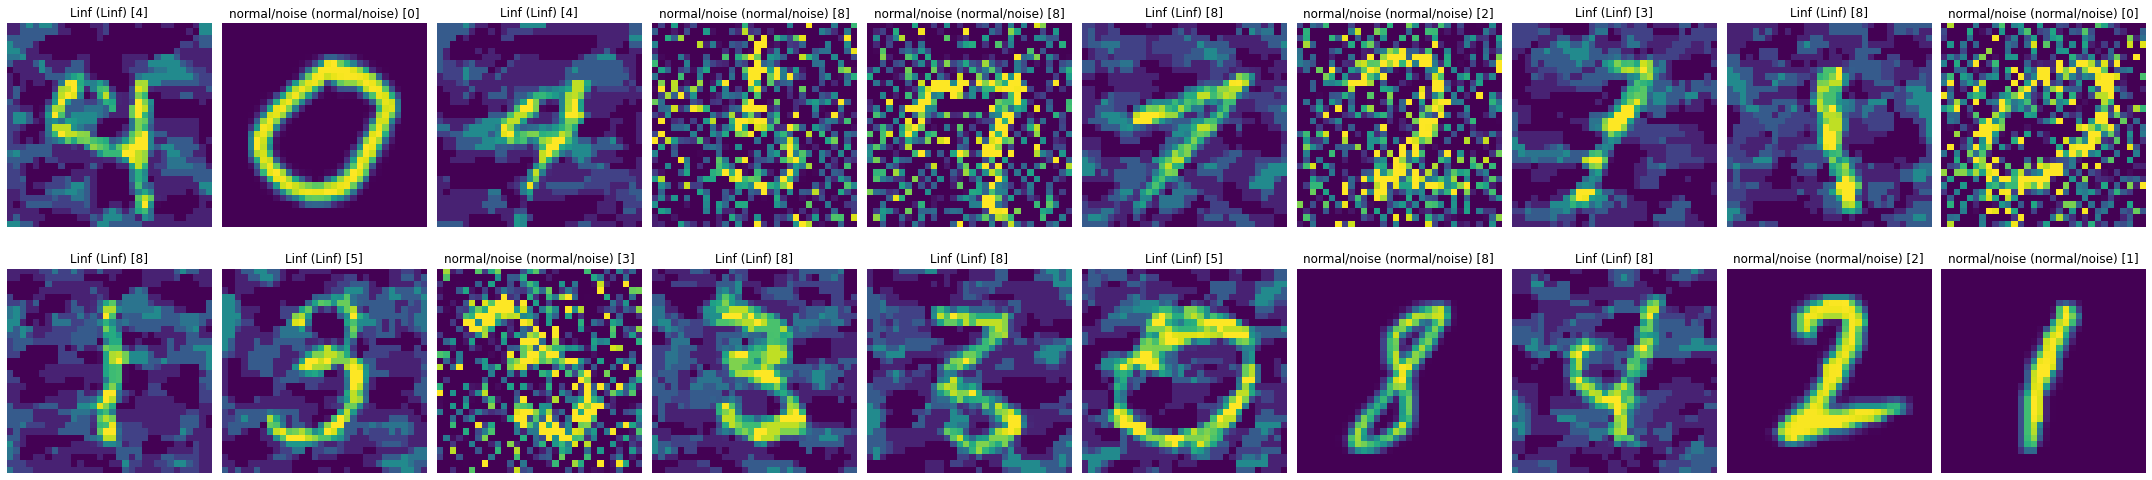

In [88]:
## FGSM global parameters

FGSM_EPSILON = 0.15

## PGD global parameters

loss_fn  = torch.nn.CrossEntropyLoss()
LOSS_FN  = torch.nn.CrossEntropyLoss()
NUM_STEPS = 10
STEP_SIZE = 0.3
EPS = 3     # 0.0, 6.1, 1./3
STEP_NORM = 2   # 'inf'
EPS_NORM = 2

fig=plt.figure(figsize=(30,8))
labels = ['normal/noise', 'Linf', 'L2']
# labels = ['normal/noise', 'Adversarial']

def inference(model, adv_model, dataset_sample, i):

    sample = dataset_sample[0]
    X = sample.unsqueeze(0)
    X = X.to(device)

    y_hat_adv = adv_model(X) 
    y_prob_adv = F.softmax(y_hat_adv, dim=1)
    _, predicted_labels_adv = torch.max(y_prob_adv, 1)

    y_hat = model(X) 
    y_prob = F.softmax(y_hat, dim=1)
    _, predicted_labels = torch.max(y_prob, 1)

    sub = fig.add_subplot(2, 10, i+1)
    # plt.subplot(2, 5, i+1)
    plt.axis('off')
    sub.set_title(labels[predicted_labels.item()] + ' (' + labels[dataset_sample[1]] + ')' + ' [' + str(predicted_labels_adv.item()) + ']')
    plt.imshow(sample[0].detach().cpu().numpy())
    plt.tight_layout()

indices = random.sample(range(0, len(valid_dataset)), 20)
valid_dataset.attack = 'pgd-linf'
for i, index in enumerate(indices):
    # fgsm_eps = np.random.uniform(0.01, 0.5)
    # fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = fgsm_eps)
    inference(model, adv_model, valid_dataset[index], i)

In [ ]:
pgd_linf = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 10, step_size = 0.01, eps = 0.1, step_norm = 'inf', eps_norm = 'inf')
pgd_l2 = PGD(loss_fn=torch.nn.CrossEntropyLoss(), num_steps = 10, step_size = 0.15, eps = 1.5, step_norm = 2, eps_norm = 2)
fgsm = FGSM(loss_fn=torch.nn.CrossEntropyLoss(), fgsm_epsilon = 0.1)
cw = torchattacks.CW(adv_model, c=15, kappa=0, steps=10, lr=0.5)
deepfool = torchattacks.DeepFool(adv_model, steps=5, overshoot=0.2)

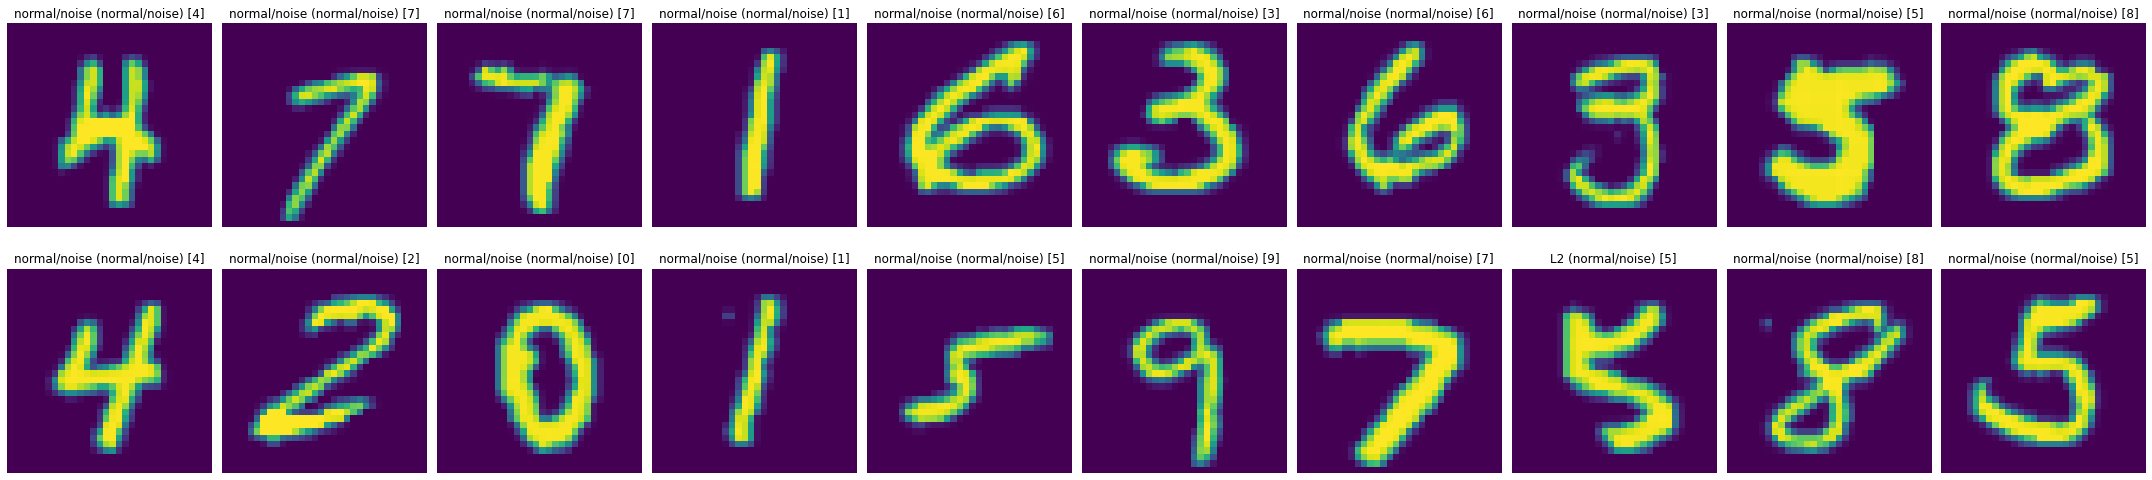

In [89]:
BATCH_SIZE = 256

inf_transformations = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),])

inf_train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=inf_transformations,
                               download=True)

inf_valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=inf_transformations)

inf_train_loader = DataLoader(dataset=inf_train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

inf_valid_loader = DataLoader(dataset=inf_valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

fig=plt.figure(figsize=(30,8))

indices = random.sample(range(0, len(inf_valid_dataset)), 20)
inf_valid_dataset.attack = 'fgsm'
for i, index in enumerate(indices):

    sample = []

    attack = torchattacks.VANILA(adv_model)
    sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), inf_valid_dataset[index][1]).squeeze(0))
    sample.append(0)

    # attack = torchattacks.GN(adv_model, std=0.1)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), inf_valid_dataset[index][1]).squeeze(0))
    # sample.append(0)

    # attack = torchattacks.BIM(adv_model, eps=40/255, alpha=4/255, steps=10)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.RFGSM(adv_model, eps=16/255, alpha=8/255, steps=5)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.EOTPGD(adv_model, eps=4/255, alpha=8/255, steps=40, eot_iter=10)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.TPGD(adv_model, eps=8/255, alpha=2/255, steps=7)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.FFGSM(adv_model, eps=8/255, alpha=10/255)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.MIFGSM(adv_model, eps=8/255, steps=5, decay=1.0)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)

    # attack = torchattacks.APGD(adv_model, norm='L2', eps=80/255, steps=100, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(2)

    # attack = torchattacks.FAB(adv_model, norm='L2', steps=100, eps=None, n_restarts=1, alpha_max=0.1, eta=1.05, beta=0.9, verbose=False, seed=0, targeted=False, n_classes=10)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(2)

    # attack = torchattacks.Jitter(adv_model, eps=0.3, alpha=2/255, steps=40, scale=10, std=0.1, random_start=True)
    # sample.append(attack(inf_valid_dataset[index][0].unsqueeze(0).to(device), torch.tensor(inf_valid_dataset[index][1], device=device).unsqueeze(0)).squeeze(0))
    # sample.append(1)
    
    inference(model, adv_model, sample, i)

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/All_attacks_varied_params_trained_model-97%.pkl', 'wb'))

In [ ]:
model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/All_attacks_varied_params_trained_model.pkl', 'rb')).load()